In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

In [3]:
# Создание SparkSession
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("WordCount") \
    .getOrCreate()

In [4]:
# Проверка сессии
print(spark)

In [6]:
# Чтение файла из HDFS
df = spark.read.json("hdfs://namenode:8020/flights.json")


In [21]:
# Вывод схемы и типов данных для датасета о продажах автомобилей
print("Схема данных для датасета 'sales.csv':")
df.printSchema()

Схема данных для датасета 'sales.csv':
root
 |-- AIR_TIME: long (nullable = true)
 |-- ARR_DELAY: long (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- DEP_DELAY: long (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DISTANCE: long (nullable = true)
 |-- FL_DATE: string (nullable = true)



In [12]:
# Подсчет общего количества записей
total_records = df.count()

# Вывод результата
print(f"Общее количество записей: {total_records}")


Общее количество записей: 1000000


In [24]:
# Удаление записей с отсутствующими значениями в ключевых полях 
cleaned_flights_df = df.dropna(subset=["DEP_DELAY", "DISTANCE"])

In [26]:
print("Количество записей в датасете  после очистки:")
print(cleaned_flights_df.count())

Количество записей в датасете  после очистки:
1000000


In [27]:
# Поиск 5 самых длинных рейсов по расстоянию
longest_flights_df = df.orderBy("DISTANCE", ascending=False).limit(5)

# Вывод результата
longest_flights_df.show()


+--------+---------+---------+---------+---------+--------+----------+
|AIR_TIME|ARR_DELAY| ARR_TIME|DEP_DELAY| DEP_TIME|DISTANCE|   FL_DATE|
+--------+---------+---------+---------+---------+--------+----------+
|     526|       -6|12.983334|       -1|22.733334|    4962|2006-01-01|
|     634|        5|19.333334|        1|    13.35|    4962|2006-01-07|
|     612|      -20|18.916666|       -2|     13.3|    4962|2006-01-25|
|     540|       -4|13.016666|      -11|22.566668|    4962|2006-01-27|
|     531|        6|13.183333|       -2|22.716667|    4962|2006-01-06|
+--------+---------+---------+---------+---------+--------+----------+



In [7]:
# Вычисление средней задержки вылета и средней задержки прибытия
average_delays = df.select(avg("DEP_DELAY").alias("average_dep_delay"),
                           avg("ARR_DELAY").alias("average_arr_delay"))

In [8]:
# Вывод результата
average_delays.show()

+-----------------+-----------------+
|average_dep_delay|average_arr_delay|
+-----------------+-----------------+
|         8.651135|         6.400658|
+-----------------+-----------------+



In [9]:
# Вычисление среднего времени задержки по каждой дате
average_delay_by_date = df.groupBy("FL_DATE") \
    .agg(
        avg("DEP_DELAY").alias("average_dep_delay"),
        avg("ARR_DELAY").alias("average_arr_delay")
    ) \
    .orderBy("FL_DATE")

In [13]:
# Вывод результата
average_delay_by_date.show(60)

+----------+------------------+--------------------+
|   FL_DATE| average_dep_delay|   average_arr_delay|
+----------+------------------+--------------------+
|2006-01-01|12.643716653422636|  10.206833919854693|
|2006-01-02|  37.4897160158697|  39.926863645855086|
|2006-01-03|26.868688439606014|  26.560912389839295|
|2006-01-04|  9.60840532089671|   6.143780804494144|
|2006-01-05| 6.013156547558104|   3.488481621787652|
|2006-01-06|3.1167084334884674|-0.46847031146115686|
|2006-01-07| 3.881189948263119| -1.3057403301305741|
|2006-01-08| 4.730844050578191|  0.5612233870096185|
|2006-01-09|2.1296001642457525|  -2.027973104757994|
|2006-01-10|1.1479423979289143|  -3.182838034625964|
|2006-01-11| 7.783398607484769|  6.0092471714534375|
|2006-01-12| 3.950574531717299|-0.15189674169683615|
|2006-01-13|  19.7891149217169|  20.812440089466396|
|2006-01-14| 7.290941317971766|   4.231626258150282|
|2006-01-15| 7.784779957876067|    4.96181132912094|
|2006-01-16| 6.362808842652796|   4.1848634590

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

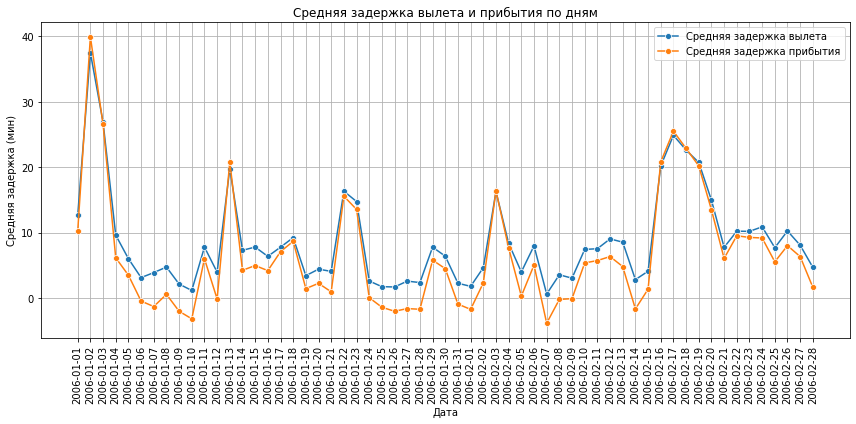

In [20]:
# Конвертация в Pandas DataFrame для визуализации
average_delay_df = average_delay_by_date.toPandas()

# Построение графика с помощью Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="FL_DATE", y="average_dep_delay", data=average_delay_df, label="Средняя задержка вылета", marker="o")
sns.lineplot(x="FL_DATE", y="average_arr_delay", data=average_delay_df, label="Средняя задержка прибытия", marker="o")
plt.xlabel("Дата")
plt.ylabel("Средняя задержка (мин)")
plt.title("Средняя задержка вылета и прибытия по дням")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()